# Multilingual factual consistency: тестовое задание

## Обработка данных и инференс модели

Мы будем работать с датасетом [mParaRel](https://github.com/coastalcph/mpararel)

In [1]:
!git clone https://github.com/coastalcph/mpararel

Cloning into 'mpararel'...
remote: Enumerating objects: 60154, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 60154 (delta 0), reused 1 (delta 0), pack-reused 60147
Receiving objects: 100% (60154/60154), 64.53 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (46008/46008), done.
Checking out files: 100% (22417/22417), done.


In [2]:
import json
import os
from os import listdir
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 30.6 MB/s 
     |████████████████████████████████| 7.6 MB 52.2 MB/s 
     |████████████████████████████████| 163 kB 74.3 MB/s 


In [136]:
from transformers import AutoTokenizer, pipeline

tokenizer = AutoTokenizer.from_pretrained(
                'bert-base-multilingual-cased',
                revision='main')

fill_mask = pipeline(task='fill-mask',
         tokenizer=tokenizer,
         model = 'bert-base-multilingual-cased',
         revision = 'main')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [137]:
def make_masks(pattern, lang):
    pat = pd.read_json(path_or_buf=f'patterns/{lang}/{pattern}', lines=True)
    tup = pd.read_json(path_or_buf=f'tuples/{lang}/{pattern}', lines=True)
    pat['pattern'] = pat['pattern'].apply(lambda x: x.replace('’', '\'').replace('—', '-'))
    pat['key'] = 0
    tup['key'] = 0
    res = pat.reset_index().merge(tup.reset_index(), on='key', how='outer')\
        [['index_x', 'pattern', 'index_y', 'sub_label', 'sub_uri', 'obj_label', 'obj_uri', 'lineid']]\
        .rename(columns={'index_x':'pattern_ind', 'index_y':'tuple_ind'}, inplace=False)
    res['masked'] = res.apply(lambda x: x.pattern.replace('[X]', x.sub_label).replace('[Y]', '[MASK]'), axis=1)
    return res

def infer(data, filename):
    data['res'] = data['masked'].progress_apply(fill_mask)
    data2 = data.explode('res', ignore_index=True)
    data2['pred_token'] = data2['res'].apply(lambda x: x['token_str'])
    data2['pred_score'] = data2['res'].apply(lambda x: x['score'])
    data2.to_csv(filename)
    return data2

In [140]:
pattern = 'P36.jsonl'
infer(make_masks(pattern, 'ru'), 'res_ru.csv')

100%|██████████| 9016/9016 [26:09<00:00,  5.75it/s]


,pattern_ind,pattern,tuple_ind,sub_label,sub_uri,obj_label,obj_uri,lineid,masked,res,pred_token,pred_score
0,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,[MASK] является столицей Азербайджан,"{'score': 0.4666118025779724, 'token': 47021, ...",Баку,0.466612
1,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,[MASK] является столицей Азербайджан,"{'score': 0.1856800764799118, 'token': 107954,...",Азербайджан,0.185680
2,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,[MASK] является столицей Азербайджан,"{'score': 0.08762569725513458, 'token': 118, '...",-,0.087626
3,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,[MASK] является столицей Азербайджан,"{'score': 0.030973663553595543, 'token': 117, ...",",",0.030974
4,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,[MASK] является столицей Азербайджан,"{'score': 0.017645971849560738, 'token': 61219...",Азербайджана,0.017646
...,...,...,...,...,...,...,...,...,...,...,...,...
45075,13,"[X], который имеет заглавную букву [Y]",643,Фландрия,Q234,Брюссель,Q239,702,"Фландрия, который имеет заглавную букву [MASK]","{'score': 0.5297743678092957, 'token': 119, 't...",.,0.529774
45076,13,"[X], который имеет заглавную букву [Y]",643,Фландрия,Q234,Брюссель,Q239,702,"Фландрия, который имеет заглавную букву [MASK]","{'score': 0.3327746093273163, 'token': 132, 't...",;,0.332775
45077,13,"[X], который имеет заглавную букву [Y]",643,Фландрия,Q234,Брюссель,Q239,702,"Фландрия, который имеет заглавную букву [MASK]","{'score': 0.06558215618133545, 'token': 131, '...",:,0.065582
45078,13,"[X], который имеет заглавную букву [Y]",643,Фландрия,Q234,Брюссель,Q239,702,"Фландрия, который имеет заглавную букву [MASK]","{'score': 0.05171678960323334, 'token': 117, '...",",",0.051717


In [143]:
infer(make_masks(pattern, 'fr'), 'res_fr.csv')

100%|██████████| 7678/7678 [22:39<00:00,  5.65it/s]


,pattern_ind,pattern,tuple_ind,sub_label,sub_uri,obj_label,obj_uri,lineid,masked,res,pred_token,pred_score
0,0,"la capitale de [X], [Y]",0,Azerbaïdjan,Q227,Bakou,Q9248,0,"la capitale de Azerbaïdjan, [MASK]","{'score': 0.12901000678539276, 'token': 10431,...",ou,0.129010
1,0,"la capitale de [X], [Y]",0,Azerbaïdjan,Q227,Bakou,Q9248,0,"la capitale de Azerbaïdjan, [MASK]","{'score': 0.04858997091650963, 'token': 44005,...",Baku,0.048590
2,0,"la capitale de [X], [Y]",0,Azerbaïdjan,Q227,Bakou,Q9248,0,"la capitale de Azerbaïdjan, [MASK]","{'score': 0.04206250235438347, 'token': 131, '...",:,0.042063
3,0,"la capitale de [X], [Y]",0,Azerbaïdjan,Q227,Bakou,Q9248,0,"la capitale de Azerbaïdjan, [MASK]","{'score': 0.04036899283528328, 'token': 118, '...",-,0.040369
4,0,"la capitale de [X], [Y]",0,Azerbaïdjan,Q227,Bakou,Q9248,0,"la capitale de Azerbaïdjan, [MASK]","{'score': 0.036528579890728, 'token': 117, 'to...",",",0.036529
...,...,...,...,...,...,...,...,...,...,...,...,...
38385,10,[Y] est la capitale de [X],697,Flandre,Q234,Bruxelles,Q239,702,[MASK] est la capitale de Flandre,"{'score': 0.1361006647348404, 'token': 73472, ...",Anvers,0.136101
38386,10,[Y] est la capitale de [X],697,Flandre,Q234,Bruxelles,Q239,702,[MASK] est la capitale de Flandre,"{'score': 0.10027884691953659, 'token': 101515...",Bruges,0.100279
38387,10,[Y] est la capitale de [X],697,Flandre,Q234,Bruxelles,Q239,702,[MASK] est la capitale de Flandre,"{'score': 0.06207257881760597, 'token': 88011,...",Charleroi,0.062073
38388,10,[Y] est la capitale de [X],697,Flandre,Q234,Bruxelles,Q239,702,[MASK] est la capitale de Flandre,"{'score': 0.05046204850077629, 'token': 83453,...",Arras,0.050462


## Анализ результатов


In [116]:
ru = pd.read_csv('res_ru.csv', index_col=0)
fr = pd.read_csv('res_fr.csv', index_col=0)
ru.head(2)

,pattern_ind,pattern,tuple_ind,sub_label,sub_uri,obj_label,obj_uri,lineid,masked,res,pred_token,pred_score
0,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,[MASK] является столицей Азербайджан,"{'score': 0.4666118025779724, 'token': 47021, ...",Баку,0.466612
1,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,[MASK] является столицей Азербайджан,"{'score': 0.1856800764799118, 'token': 107954,...",Азербайджан,0.185680


### Доля правильно заполненных пропусков
Для каждой пары паттерн-тупл посмотрим, предложила ли модель правильный ответ среди топ-5 ответов, посчитаем долю таких пар.

In [117]:
# get the share of pairs pattern-tuple, where among top-5 answers there is a correct one
corrects_ru = ru.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
corrects_ru.sum()/corrects_ru.count()

0.08473824312333629

In [118]:
corrects_fr = fr.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
corrects_fr.sum()/corrects_fr.count()

0.2692107319614483

Видно, что она небольшая: для французского 27%, а для русского вообще 8%. Посмотрим, в чем дело - посмотрим, какие паттерны мы заполнили лучше и хуже всего:

In [119]:
corrects_ru_set = ru.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()[corrects_ru]
corrects_ru_set.groupby(['pattern'])['pred_token'].count().sort_values(ascending=False)

pattern
столица [X] - [Y]                         172
[Y], это столица [X]                       97
[Y], столица [X]                           95
[X] столица, [Y]                           92
[Y] - столица [X]                          91
[Y], то есть столица [X]                   79
[Y] является столицей [X]                  74
заглавная буква [X] - [Y]                  24
[X], который имеет столицу [Y]             18
капитал [X] - [Y]                          11
капитал [X], [Y]                            9
[X], который имеет заглавную букву [Y]      1
столица [X] [Y]                             1
Name: pred_token, dtype: int64

In [120]:
ru_bad = [1, 2, 7, 8, 9, 11, 13, 10]
ru[['pattern_ind', 'pattern']].drop_duplicates()
# плохие индексы - 1, 2, 7, 8, 9, 11, 13; 10 повторяется

,pattern_ind,pattern
0,0,[Y] является столицей [X]
3220,1,"[X] столица, [Y]"
6440,2,столица [X] [Y]
9660,3,"[Y], то есть столица [X]"
12880,4,"[Y], это столица [X]"
16100,5,"[Y], столица [X]"
19320,6,столица [X] - [Y]
22540,7,"капитал [X], [Y]"
25760,8,"[X], который имеет столицу [Y]"
28980,9,заглавная буква [X] - [Y]


Аналогично для французского:

In [121]:
corrects_fr_set = fr.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()[corrects_fr]
corrects_fr_set.groupby(['pattern'])['pred_token'].count().sort_values(ascending=False)

pattern
[Y], c'est la capitale de [X]    506
[Y], la capitale de [X]          348
[Y] est la capitale de [X]       336
la capitale de [X] est [Y]       256
le capital de [X] est [Y]        245
la capitale de [X], [Y]          198
[X], qui a la capitale [Y]       118
[X], qui a le capital [Y]         59
[X], qui a la majuscule [Y]        1
Name: pred_token, dtype: int64

In [122]:
fr_bad = [1, 3, 6, 9, 7]
fr[['pattern_ind', 'pattern']].drop_duplicates()
# плохие - 1, 3, 6, 9; 7 - повторяется

,pattern_ind,pattern
0,0,"la capitale de [X], [Y]"
3490,1,la majuscule de [X] est [Y]
6980,2,"[X], qui a la capitale [Y]"
10470,3,le capital de [X] est [Y]
13960,4,"[Y], la capitale de [X]"
17450,5,"[Y], c'est la capitale de [X]"
20940,6,"[X], qui a la majuscule [Y]"
24430,7,"[Y], c'est la capitale de [X]"
27920,8,la capitale de [X] est [Y]
31410,9,"[X], qui a le capital [Y]"


In [123]:
new_corrects_ru_set = corrects_ru_set[~corrects_ru_set['pattern_ind'].isin(ru_bad)]
new_corrects_fr_set = corrects_fr_set[~corrects_fr_set['pattern_ind'].isin(fr_bad)]
new_ru = ru[~ru['pattern_ind'].isin(ru_bad)]
new_fr = fr[~fr['pattern_ind'].isin(fr_bad)]

In [124]:
new_corrects_ru = new_ru.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
new_corrects_ru.sum()/new_corrects_ru.count()

0.13509316770186336

In [125]:
new_corrects_fr = new_fr.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
new_corrects_fr.sum()/new_corrects_fr.count()

0.36031518624641834

Видим, что среди корректных паттернов доля угаданных пар выше для обоих языков - 14% и 36% соответственно.

### Распределение скоров модели

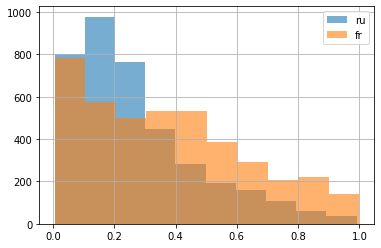

In [126]:
import matplotlib.pyplot as plt

# get the top-1 answer for every pattern-tuple pair
ru_max = new_ru.groupby(['pattern', 'sub_label', 'obj_label'])['pred_score'].max()
fr_max = new_fr.groupby(['pattern', 'sub_label', 'obj_label'])['pred_score'].max()

# get the distribution of model scores
ru_max.hist(alpha=0.6, label='ru')
fr_max.hist(alpha=0.6, label='fr')
plt.legend()
plt.show()

### Какие объекты мы восстанавливаем хорошо, а какие плохо?

In [127]:
# города, которые мы чаще всего угадывали, и доля угаданных случаев, от всех, где этот город является объектом
new_corrects_ru_set.groupby(['obj_label'])['pred_token'].count().reset_index()\
    .merge(new_ru[~new_ru['pattern_ind'].isin(ru_bad)].groupby(['obj_label'])['pred_token'].count().reset_index(), on='obj_label', how='inner')\
    .set_index('obj_label')\
    .apply(lambda x: 1.0*x['pred_token_x']/x['pred_token_y']*5, axis=1).sort_values(ascending=False)

obj_label
Мадрид       1.000000
Минск        1.000000
Казань       1.000000
Барселона    1.000000
Рим          0.962963
Белград      0.958333
Токио        0.944444
Мюнхен       0.944444
София        0.916667
Берлин       0.916667
Киев         0.888889
Прага        0.875000
Варшава      0.866667
Загреб       0.833333
Москва       0.833333
Торонто      0.833333
Лондон       0.796296
Париж        0.766667
Милан        0.611111
Баку         0.541667
Манчестер    0.166667
dtype: float64

In [128]:
new_corrects_fr_set.groupby(['obj_label'])['pred_token'].count().reset_index()\
    .merge(new_fr[~new_fr['pattern_ind'].isin(fr_bad)].groupby(['obj_label'])['pred_token'].count().reset_index(), on='obj_label', how='inner')\
    .set_index('obj_label')\
    .apply(lambda x: 1.0*x['pred_token_x']/x['pred_token_y']*5, axis=1).sort_values(ascending=False).head(30)

obj_label
Mansfield         1.000000
Odessa            1.000000
Lyon              1.000000
Cork              1.000000
Tulsa             1.000000
Caracas           1.000000
Mobile            1.000000
Durham            1.000000
Leeds             1.000000
Bolton            1.000000
Newcastle         1.000000
Hampton           1.000000
Dudley            1.000000
Porto             1.000000
Tallinn           1.000000
Anvers            1.000000
Bagdad            0.966667
Constantinople    0.944444
Valence           0.944444
Dublin            0.944444
Londres           0.888889
Florence          0.888889
Madrid            0.875000
Moscou            0.857143
Mary              0.833333
Casablanca        0.833333
Galway            0.833333
Genève            0.833333
Wellington        0.833333
Saga              0.833333
dtype: float64

### Какие субъекты дают больше всего информации?
Посмотрим в целом на топ субъектов, у которых мы угадали субъекты в наибольшей доле случаев:

In [129]:
new_corrects_ru_set.groupby(['sub_label'])['pred_token'].count().reset_index()\
    .merge(new_ru[(~new_ru['pattern_ind'].isin(ru_bad))].groupby(['sub_label'])['pred_token'].count().reset_index(), on='sub_label', how='inner')\
    .set_index('sub_label')\
    .apply(lambda x: 1.0*x['pred_token_x']/x['pred_token_y']*5, axis=1).sort_values(ascending=False).head(30)

sub_label
Азербайджан                                                   1.0
Римская республика                                            1.0
Лацио                                                         1.0
Милан                                                         1.0
Минская область                                               1.0
Азербайджанская ССР                                           1.0
Мюнхен                                                        1.0
Оккупация Японии                                              1.0
Парижская коммуна                                             1.0
Первая Испанская Республика                                   1.0
Первая Чехословацкая Республика                               1.0
Польская Народная Республика                                  1.0
Польская Республика                                           1.0
Прага-запад                                                   1.0
Реставрация Бурбонов                                          1.0


In [130]:
omonyms_ru = new_ru[new_ru.apply(lambda x: x['obj_label'][0:-2] in x['sub_label'], axis=1)][['tuple_ind','sub_label','sub_uri','obj_label','obj_uri']].drop_duplicates()
omonyms_ru

,tuple_ind,sub_label,sub_uri,obj_label,obj_uri
5,1,Бродовский район,Q2599799,Броды,Q465104
45,9,Александрия,Q29943,Александрия,Q87
50,10,Коломбо,Q606287,Коломбо,Q35381
70,14,Сити-оф-Карлайл,Q1094110,Карлайл,Q192896
90,18,Дакка,Q1850485,Дакка,Q1354
...,...,...,...,...,...
3125,625,Ананд (округ),Q485683,Ананд,Q1798750
3145,629,Триполитания,Q192435,Триполи,Q3579
3150,630,Римская республика,Q17167,Рим,Q220
3180,636,Сити-оф-Лидс,Q774015,Лидс,Q39121


In [131]:
tmp = new_ru.merge(omonyms_ru, on='tuple_ind', suffixes=(None, '_y'))\
            .groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tmp.sum()/tmp.count()

0.10569105691056911

In [132]:
omonyms_fr = new_fr[new_fr.apply(lambda x: x['obj_label'][0:-2] in x['sub_label'], axis=1)][['tuple_ind','sub_label','sub_uri','obj_label','obj_uri']].drop_duplicates()
omonyms_fr

,tuple_ind,sub_label,sub_uri,obj_label,obj_uri
45,9,Alexandrie,Q29943,Alexandrie,Q87
50,10,Colombo,Q606287,Colombo,Q35381
70,14,cité de Carlisle,Q1094110,Carlisle,Q192896
130,26,comté d'Athens,Q485588,Athens,Q755420
155,31,Aberdeenshire,Q189912,Aberdeen,Q36405
...,...,...,...,...,...
3385,677,Minsk,Q192959,Minsk,Q2280
3390,678,district d'Anand,Q485683,Anand,Q1798750
3410,682,Tripolitaine,Q192435,Tripoli,Q3579
3450,690,cité de Leeds,Q774015,Leeds,Q39121


In [133]:
tmp2 = new_fr.merge(omonyms_fr, on='tuple_ind', suffixes=(None, '_y'))\
            .groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tmp2.sum()/tmp2.count()

0.5873983739837398

In [134]:
a = new_ru[['sub_label', 'obj_label']].drop_duplicates().groupby('sub_label')['obj_label'].apply(list).reset_index()
omonyms2_ru = a[a['obj_label'].apply(len) > 1]
omonyms2_ru

,sub_label,obj_label
0,Аббасидский халифат,"[Дамаск, Багдад]"
7,Австро-Венгрия,"[Вена, Будапешт]"
168,Европейский союз,"[Страсбург, Брюссель]"
219,Канада,"[Монреаль, Оттава]"
244,Китайская Республика,"[Тайбэй, Нанкин]"
249,Колорадо,"[Денвер, Колумбус]"
254,Конфедеративные Штаты Америки,"[Монтгомери, Ричмонд]"
257,Королевство Англия,"[Уинчестер, Вестминстер, Лондон]"
270,Королевство Италия,"[Флоренция, Турин, Рим]"
277,Королевство Сицилия,"[Неаполь, Палермо]"


In [135]:
tmp = new_ru.merge(omonyms2_ru, on='sub_label', suffixes=(None, '_y'))\
            .groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tmp.sum()/tmp.count()

0.08854166666666667

Да, в русском процент угаданных получился меньше среднего (9% против 14%).

In [136]:
a2 = new_fr[['sub_label', 'obj_label']].drop_duplicates().groupby('sub_label')['obj_label'].apply(list).reset_index()
omonyms2_fr = a2[a2['obj_label'].apply(len) > 1]
omonyms2_fr

,sub_label,obj_label
34,Autriche-Hongrie,"[Vienne, Budapest]"
111,Empire romain,"[Constantinople, Rome]"
402,Union européenne,"[Strasbourg, Bruxelles]"
437,califat abbasside,"[Damas, Bagdad]"
643,royaume d'Angleterre,"[Winchester, Westminster, Londres]"
647,royaume d'Italie,"[Florence, Turin, Rome]"
662,royaume de Sicile,"[Naples, Palerme]"
682,États confédérés d'Amérique,"[Montgomery, Richmond]"


In [137]:
tmp2 = new_fr.merge(omonyms2_fr, on='sub_label', suffixes=(None, '_y'))\
            .groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tmp2.sum()/tmp2.count()

0.4351851851851852

### Сравнение языков


In [138]:
new_corrects_ru_set.loc[8358, ['sub_label', 'obj_label', 'pred_token']]

sub_label                Римская республика
obj_label                               Рим
pred_token    [Рим, Рима, Rome, Риме, Roma]
Name: 8358, dtype: object

Посмотрим, как соотносятся между собой одни и те же туплы (по lineid) на разных языках. Угадываем ли мы их одинаково хорошо? Или есть те, которые угадываем только в одном? Также в датасете были неповторяющиеся туплы, их тут не учитываю.

In [183]:
tt = new_ru.groupby(['pattern_ind', 'lineid', 'pattern', 'sub_label', 'obj_label'], as_index=True)['pred_token'].apply(list).reset_index()
tt['res'] = tt.apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tuples_rate_ru = tt.groupby(['lineid', 'sub_label', 'obj_label']).apply(lambda x: sum(x['res'])).reset_index()

In [184]:
tt2 = new_fr.groupby(['pattern_ind', 'lineid', 'pattern', 'sub_label', 'obj_label'], as_index=True)['pred_token'].apply(list).reset_index()
tt2['res'] = tt2.apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tuples_rate_fr = tt2.groupby(['lineid', 'sub_label', 'obj_label']).apply(lambda x: sum(x['res'])).reset_index()

In [185]:
b = tuples_rate_ru.merge(tuples_rate_fr, on=['lineid'])
b

,lineid,sub_label_x,obj_label_x,0_x,sub_label_y,obj_label_y,0_y
0,0,Азербайджан,Баку,6,Azerbaïdjan,Bakou,0
1,2,Кук,Чикаго,0,comté de Cook,Chicago,1
2,3,Форт-Бенд,Ричмонд,0,comté de Fort Bend,Richmond,0
3,4,Кейюга,Оберн,0,comté de Cayuga,Auburn,0
4,6,Гранд-Эст,Страсбург,0,Grand Est,Strasbourg,3
...,...,...,...,...,...,...,...
634,698,Северо-Восточный Линкольншир,Гримсби,0,North East Lincolnshire,Grimsby,0
635,699,Валенсия,Валенсия,0,province de Valence,Valence,6
636,700,Типикэну,Лафейетт,0,comté de Tippecanoe,Lafayette,0
637,701,Мазовецкое воеводство,Варшава,4,voïvodie de Mazovie,Varsovie,2


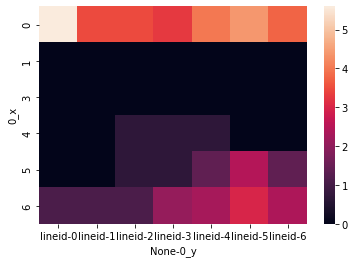

In [187]:
from math import log
import seaborn as sns

sns.heatmap(b.groupby(['0_x', '0_y'])['lineid'].count().apply(log).reset_index().pivot(index=['0_x'], columns=['0_y']).fillna(0))